In [28]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

import torch
import matplotlib.pyplot as plt
import numpy as np

In [29]:
train_data = CIFAR10(
    root='../data',          
    train=True,
    download=False,
    transform=transforms.ToTensor()
)
test_data = CIFAR10(
    root='../data',
    train=False,
    download = False,
    transform=transforms.ToTensor()
)

In [30]:
def split_train_data(len_dataset, split_percent = 0.1, seed = 99):
    num_of_valid = int(len_dataset * split_percent)
    np.random.seed(seed)
    idxs = np.random.permutation(len_dataset)
    return idxs[num_of_valid:], idxs[:num_of_valid]

In [31]:
split_percent = 0.2
random_seed = 42

train_indices, valid_indices = split_train_data(len(train_data), split_percent, random_seed)

In [32]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(train_data, batch_size, sampler = train_sampler)

valid_sampler = SubsetRandomSampler(valid_indices)
valid_dl = DataLoader(train_data, batch_size, sampler = valid_sampler)

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class custom_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))# [batch, 64, 8, 8]
        x = self.pool(F.relu(self.conv3(x))) 
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [34]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
        
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return[to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, device)
    def __len__(self):
        return len(self.dl)

In [35]:
device = get_default_device()
model = custom_CNN(10)
model = model.to(device)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [36]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  preds = model(xb)
  loss = loss_func(preds, yb)
  if opt:
    loss.backward()
    opt.step()
    opt.zero_grad()
  metric_result=None
  if metric:
    metric_result = metric(preds, yb)
  return loss.item(), len(xb), metric_result

In [37]:
def evaluate(model, loss_func, valid_dl, metric = None):
  with torch.no_grad():
    results = [loss_batch(model, loss_func, xb, yb, metric=metric) for xb, yb in valid_dl]

    losses, nums, metrics = zip(*results)

    total = np.sum(nums)

    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None
    if metric:
      avg_metric = np.sum(np.multiply(metrics, nums))/total
    return avg_loss, total, avg_metric

In [38]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric = None, opt_fn = None):
  train_losses, val_losses, val_metrics = [], [], []
  if not opt_fn:
    opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(), lr = lr)

  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
    
    model.eval()
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

    if not metric:
      print('Epoch[{}/{}], train_loss: {:4f}, val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
    else:
      print('Epoch[{}/{}], train_loss: {:.4f}, val_loss{:.4f},val_{}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__,val_metric))
  return train_losses, val_losses, val_metrics


In [39]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.sum(preds == labels).item()/len(preds)

In [40]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.005

In [41]:
history = fit(num_epochs, lr, model, F.cross_entropy, train_dl, valid_dl, metric = accuracy, opt_fn = opt_fn)
train_losses, val_losses, val_metrics = history

Epoch[1/10], train_loss: 1.3976, val_loss1.3597,val_accuracy: 0.5138
Epoch[2/10], train_loss: 1.2568, val_loss1.1681,val_accuracy: 0.5775
Epoch[3/10], train_loss: 1.0090, val_loss1.1102,val_accuracy: 0.6070
Epoch[4/10], train_loss: 0.9748, val_loss1.0375,val_accuracy: 0.6366
Epoch[5/10], train_loss: 1.1323, val_loss0.9674,val_accuracy: 0.6625
Epoch[6/10], train_loss: 1.0046, val_loss0.9936,val_accuracy: 0.6482
Epoch[7/10], train_loss: 0.9819, val_loss1.0243,val_accuracy: 0.6450
Epoch[8/10], train_loss: 0.7895, val_loss0.9349,val_accuracy: 0.6754
Epoch[9/10], train_loss: 0.7747, val_loss0.9330,val_accuracy: 0.6824
Epoch[10/10], train_loss: 0.9417, val_loss1.0351,val_accuracy: 0.6462


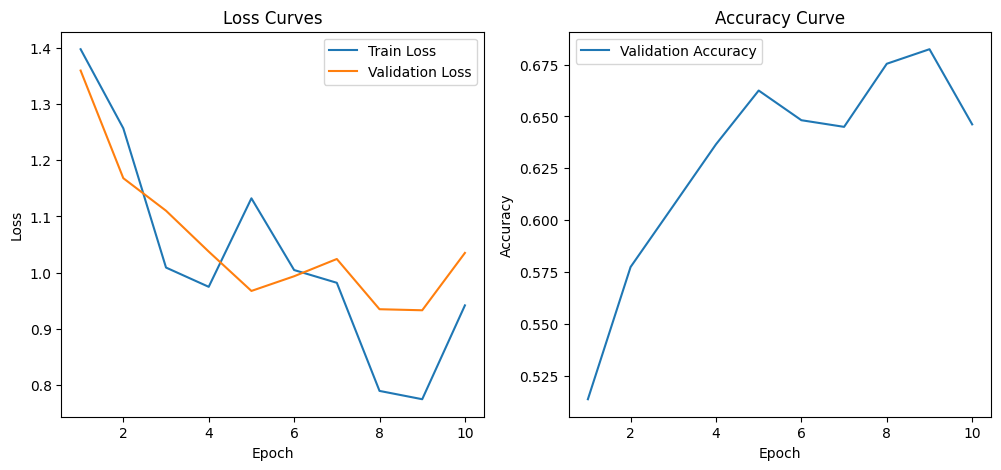

In [42]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(epochs, val_metrics, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

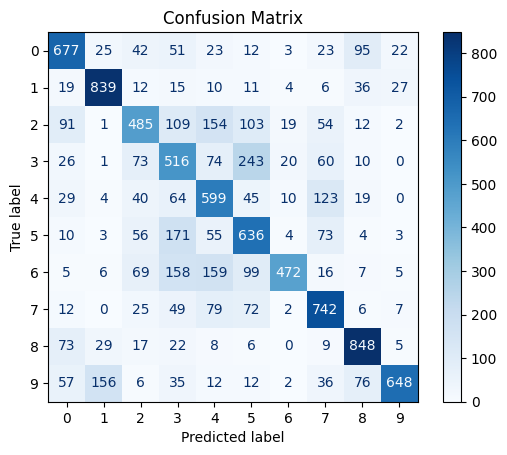

In [43]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for xb, yb in valid_dl:
        preds = model(xb)
        _, predicted = torch.max(preds, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()